In [45]:
import sys
sys.path.append("..") # To get storm code

import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import joblib

from typing import List, Dict

In [2]:
# Internal imports
from src.db import StormDB

sdb = StormDB()

# Helper
Not everything exists in the codebase, helper functions that might need to be added in future version will be here

In [39]:
class FeatureSelector(BaseEstimator, TransformerMixin):
        
    def __init__(self, feature_names=[]):
        self.feature_names = feature_names

    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        return X[self.feature_names]

# Preparation
During Storm runs the Weatherboy (instantiated model wrapper) will be handed a list of track ids that need results. It will then on its own have to source the necessary fields, process them and return prediction. **The model pipeline itself starts upon retrieval of the necessary fields.** From there it will be transformed, imputed and scored by the model. This preparation step must be kept minimal, no filtering no transforming, nothing that a simple weatherboy pipeline could not handle and nothing the model is doing.

In [4]:
storm_name = 'film_vg_instrumental_v2'
fields = {'last_updated':0} # The only fields not needed are the metadata for runs

In [6]:
# First grab the targets. These will be 1s in the prediction
target_playlist = sdb.get_config('film_vg_instrumental_v2')['great_targets']
target_track_ids = sdb.get_loaded_playlist_tracks(target_playlist)
target_tracks = sdb.get_track_info(target_track_ids, fields=fields)

In [7]:
# Next we need to get a sample of tracks that are not 1s. For a first pass we will
# grab everything by the artists in the last 5 years. We will sample downstream

artists = []
[artists.extend(track['artists']) for track in target_tracks]

non_target_track_ids = sdb.get_tracks_from_artists(artists, start_date='2017-01-01', end_date='2023-01-01')
non_target_tracks = sdb.get_track_info(non_target_track_ids, fields=fields)

In [8]:
# unify into one dataframe
df = (
    pd.DataFrame.from_records(target_tracks+non_target_tracks)
    .drop_duplicates('_id')
    .set_index('_id')
)

df['target'] = 0
df.loc[df[df.index.isin(target_track_ids)].index, 'target'] = 1

In [9]:
# Create an even sample of tracks, this won't happen during runs
sampled = shuffle(df.groupby('target').head(len(target_track_ids)), random_state=42)
sampled.target.value_counts()

0    233
1    191
Name: target, dtype: int64

# Modeling
We want to try and predict the songs that I like. Out of 25,676, only ~200 are 'great_targets', which is a <.5% discovery rate. Every Transformation will be stored in an SKLearn pipeline for easy saving and loading. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(sampled, sampled['target'])

## Sample Model Run
This is prototype of a model pipeline fit and save

In [40]:
model_name = 'base_all_features__dtc_test' # For use in model registry

model_pipeline = Pipeline([
    ('feature_selection', FeatureSelector(
        feature_names = [
            'duration_ms', 
            'acousticness',
            'danceability', 
            'energy', 
            'instrumentalness', 
            'key',
            'liveness', 
            'loudness', 
            'mode', 
            'speechiness', 
            'tempo',
            'time_signature', 
            'valence'
        ])
    ),
    ('imputer', SimpleImputer(strategy='constant', fill_value=.5)),
    ('clf', tree.DecisionTreeClassifier(
        class_weight={0:.05, 1:.95}, 
        max_depth=8)
    )
])

In [41]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_selection',
                 FeatureSelector(feature_names=['duration_ms', 'acousticness',
                                                'danceability', 'energy',
                                                'instrumentalness', 'key',
                                                'liveness', 'loudness', 'mode',
                                                'speechiness', 'tempo',
                                                'time_signature', 'valence'])),
                ('imputer', SimpleImputer(fill_value=0.5, strategy='constant')),
                ('clf',
                 DecisionTreeClassifier(class_weight={0: 0.05, 1: 0.95},
                                        max_depth=8))])

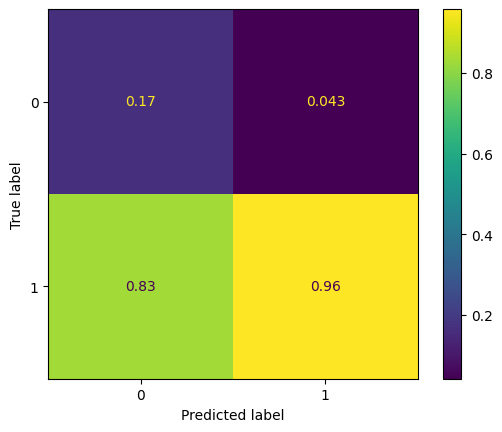

In [43]:
ConfusionMatrixDisplay(confusion_matrix(model_pipeline.predict(X_test), y_test, normalize='pred'), display_labels=model_pipeline.classes_).plot()

In [46]:
# Saving
joblib.dump(model_pipeline, f'../models/{model_name}.pkl', compress = 1)

['../models/base_all_features__dtc_test.pkl']

In [47]:
# Load and test it can indeed be scored
loaded_pipeline = joblib.load(f'../models/{model_name}.pkl')

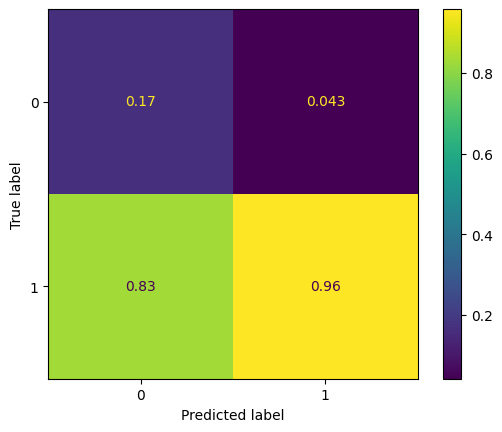

In [48]:
ConfusionMatrixDisplay(confusion_matrix(loaded_pipeline.predict(X_test), y_test, normalize='pred'), display_labels=model_pipeline.classes_).plot()